This notebook is based on 
- https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py and 
- Gumbel-softmax https://arxiv.org/abs/1611.01144
- concrete distribution https://arxiv.org/abs/1611.00712
- https://github.com/EderSantana/gumbel

### `NOTE: when using adam(and nadam) for optimizer, loss tends to nan`

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, Reshape, Activation
from keras.activations import softmax
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist

Using CNTK backend


In [2]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
batch_size = 100
original_dim = 784
latent_dim = 10
categorical_dim = 20 # one-of-K vector
intermediate_dim = 392
nb_epoch = 30
inv_tau = 20

In [4]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
alpha = Dense(latent_dim*categorical_dim)(h)
reshape_alpha = Reshape((latent_dim, categorical_dim, ))(alpha)
pi = Activation('softmax')(reshape_alpha)

In [5]:
def gumbel_softmax(pi):
    gumbel_softmax_arg = (K.log(pi+K.epsilon()) 
                          - K.log(-K.log(K.random_uniform_variable((latent_dim, categorical_dim), 0., 1.))))*inv_tau
    y = softmax(K.reshape(gumbel_softmax_arg, (-1, latent_dim, categorical_dim)))
    return K.reshape(y, (-1, latent_dim*categorical_dim))


d:\programsoft\python36_x64\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Input('inp..., outputs=Composite(...)`
  


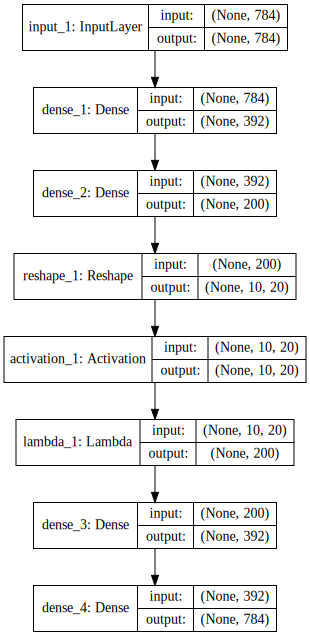

In [6]:
z = Lambda(gumbel_softmax, output_shape=(latent_dim*categorical_dim,))(pi)

decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

vae = Model(input=x, output=x_decoded_mean)
SVG(model_to_dot(vae, show_shapes=True).create(prog='dot', format='svg'))

In [7]:
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = K.sum(pi*K.log(categorical_dim*pi), axis=(-1, -2))
    return xent_loss - kl_loss

In [8]:
vae.compile(optimizer='adadelta', loss=vae_loss)

In [9]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [10]:
vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

d:\programsoft\python36_x64\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 17s 278us/step - loss: 169.4131 - val_loss: 161.2835
Epoch 2/30
60000/60000 [==============================] - 17s 282us/step - loss: 161.3740 - val_loss: 159.8383
Epoch 3/30
60000/60000 [==============================] - 16s 271us/step - loss: 157.6950 - val_loss: 156.8824
Epoch 4/30
60000/60000 [==============================] - 17s 284us/step - loss: 156.0763 - val_loss: 155.2029
Epoch 5/30
60000/60000 [==============================] - 18s 306us/step - loss: 155.2288 - val_loss: 155.0031
Epoch 6/30
60000/60000 [==============================] - 17s 284us/step - loss: 155.1623 - val_loss: 154.8197
Epoch 7/30
60000/60000 [==============================] - 17s 277us/step - loss: 154.7896 - val_loss: 154.4135
Epoch 8/30
60000/60000 [==============================] - 17s 280us/step - loss: 154.6973 - val_loss: 154.2138
Epoch 9/30
60000/60000 [==============================] - 19s 

In [11]:
# build a model to project inputs on the latent space
encoder = Model(x, pi)
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

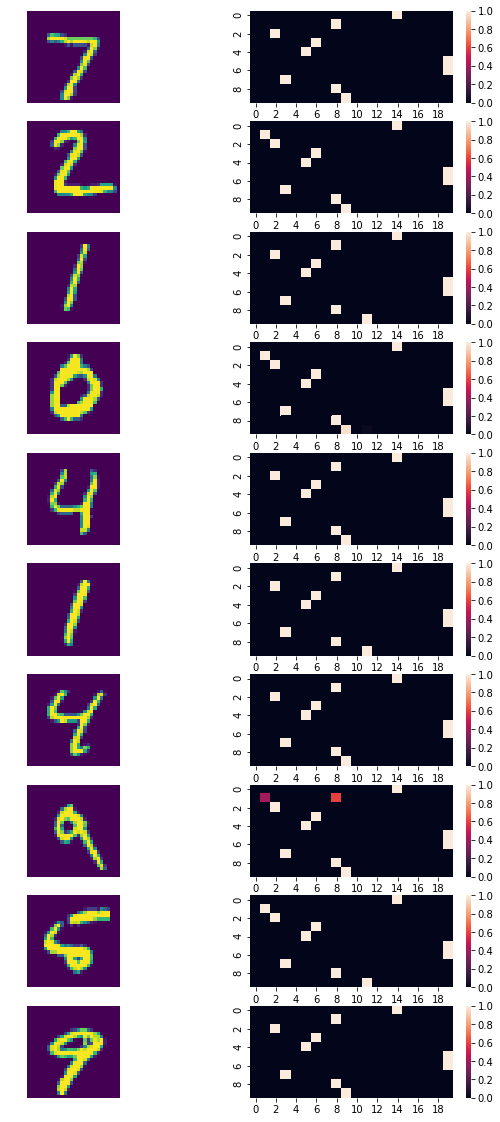

In [12]:
plt.figure(figsize=(10, 20))

n = 10
im_index = 1

for i in range(1, n+1):
    plt.subplot(n, 2, im_index)
    plt.axis('off')
    plt.imshow(x_test[i-1].reshape((28,28)))
    im_index += 1

    plt.subplot(n, 2, im_index)
    ax = sns.heatmap(x_test_encoded[i-1])
    im_index += 1
plt.savefig('gumbel_vae_mnist_encode.pdf')
plt.show()

In [13]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim*categorical_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

d:\programsoft\python36_x64\lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input1469") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


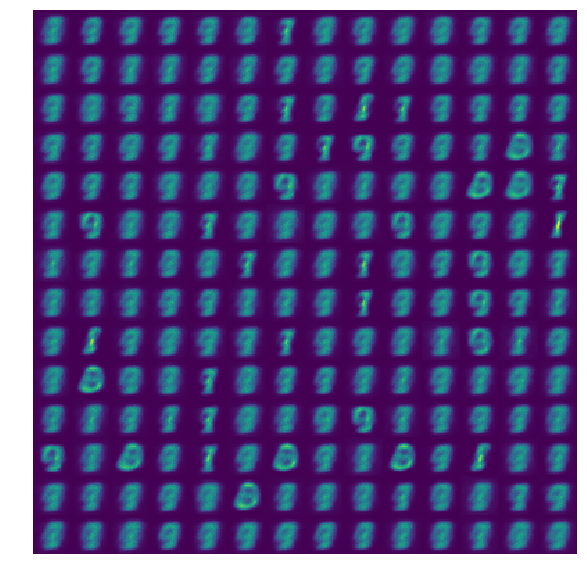

In [14]:
n = 14
digit_size = 28
figure = np.zeros((digit_size*n, digit_size*n))
# random sampling
for i in range(n):
    for j in range(n):
        data = np.zeros(categorical_dim*latent_dim)
        for index, nonzero_index in enumerate(np.random.randint(0, categorical_dim, latent_dim)):
            data[nonzero_index+index*categorical_dim] += 1
                        
        z_sample = np.array([data])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(figure)
plt.savefig('gumbel_vae_mnist_decode.pdf')
plt.show()